# Bayesian Smoothing

In GSS data -- and many other surveys -- it can be hard to track a population proportion over time because we survey different people at different times, and survey sizes tend to vary.
At the same time, we have background information to suggest that the underlying proportion changes slowly over time.

So we need a method that takes into account, in a principled way, both sample sizes and prior information about the smoothness of the underlying trends.

This example is based on Chapter 10 of *[Probably Overthinking It: How to Use Data to Answer Questions, Avoid Statistical Traps, and Make Better Decisions](https://greenteapress.com/wp/probably-overthinking-it)*, University of Chicago Press, 2023.

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
# Install empiricaldist if we don't already have it

try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [3]:
# download utils.py

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download(
    "https://github.com/AllenDowney/ProbablyOverthinkingIt/raw/book/notebooks/utils.py"
)

<IPython.core.display.Javascript object>

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utils import decorate

# Set the random seed so we get the same results every time
np.random.seed(17)

<IPython.core.display.Javascript object>

## Data

As an example, we'll use data from the General Social Survey.

In [5]:
# This dataset is prepared in GssExtract/notebooks/02_make_extract-2022_3a.ipynb

DATA_PATH = "https://github.com/AllenDowney/GssExtract/raw/main/data/interim/"
filename = "gss_extract_2022_3a.hdf"
download(DATA_PATH + filename)

<IPython.core.display.Javascript object>

In [6]:
gss = pd.read_hdf(filename, "gss")
gss.shape

(72390, 57)

<IPython.core.display.Javascript object>

In [7]:
gss["cohort"] = gss["cohort"].replace(9999, np.nan)
gss["cohort"].isna().sum()

755

<IPython.core.display.Javascript object>

In [8]:
def round_to_decade(x):
    return (x // 10) * 10


gss["cohort10"] = gss["cohort"].apply(round_to_decade)
gss["cohort10"].value_counts(dropna=False).sort_index()

cohort10
1880.0       45
1890.0      501
1900.0     1722
1910.0     3616
1920.0     5862
1930.0     7115
1940.0    10925
1950.0    14273
1960.0    11699
1970.0     7681
1980.0     5088
1990.0     2563
2000.0      545
NaN         755
Name: count, dtype: int64

<IPython.core.display.Javascript object>

Specifically, we'll look at responses to [this question](https://gssdataexplorer.norc.org/variables/434/vshow):


> Taken all together, how would you say things are these days--would you say that you are very happy, pretty happy, or not too happy?

With possible responses

```
1	Very happy	
2	Pretty happy
3	Not too happy
```

In [9]:
xvar = "year"
yvar = "happy"
yval = 1

series = gss[yvar]
series.value_counts()

happy
2.0    37446
1.0    21550
3.0     8681
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [10]:
xlim = [1970.5, 2024.5]
ylim = [0, 75]

<IPython.core.display.Javascript object>

Using the `bayesian_smooth` function, we can find the posterior mean line (in log-odds space, so not generally linear in probability space).

Notice that it doesn't give much weight to the first and last points, which are based on small sample sizes, in contrast to most forms of regression, which give a lot of weight to points far from the line (even when weighted by sample size) and points at the beginning and end of the interval.

<Axes: xlabel='x'>

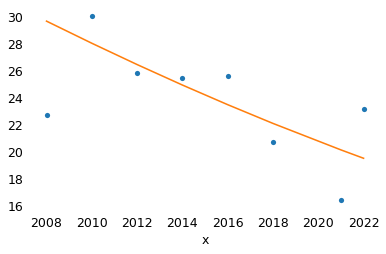

<IPython.core.display.Javascript object>

In [11]:
from smooth import bayesian_smooth

subset = gss.query("cohort10==1990").dropna(subset=[xvar, yvar])

actual, pred = bayesian_smooth(subset, xvar, yvar, yval)
actual.plot(style="o")
pred.plot()

## Linear

Here's how the linear version of the model works -- the next section shows the quadratic version.
Either of these could be used to implement a local regression model, where the estimate for each point is based on a centered interval.

This implementation of the model uses a grid algorithm, which has the advantage of being fast and deterministic, in contrast to an MCMC implementation. 

Centering the data make the grid more effective.

In [12]:
m = subset["year"].median()
m = 2012
m

2012

<IPython.core.display.Javascript object>

In [13]:
subset["y"] = subset[yvar] == yval
subset["x"] = subset["year"] - m

<IPython.core.display.Javascript object>

Prepare the data by computing `n` and `k` at each time step.

In [14]:
ns = subset.groupby("x")["y"].count()
ns

x
-4      22
-2      90
 0     151
 2     228
 4     395
 6     406
 9     675
 10    592
Name: y, dtype: int64

<IPython.core.display.Javascript object>

In [15]:
ks = subset.groupby("x")["y"].sum()
xs = ks.index
ks

x
-4       5
-2      27
 0      39
 2      58
 4     101
 6      84
 9     111
 10    137
Name: y, dtype: int64

<IPython.core.display.Javascript object>

In [16]:
actual = ks / ns
actual.index = xs + m
actual

x
2008    0.227273
2010    0.300000
2012    0.258278
2014    0.254386
2016    0.255696
2018    0.206897
2021    0.164444
2022    0.231419
Name: y, dtype: float64

<IPython.core.display.Javascript object>

Make prior distributions for the parameters.

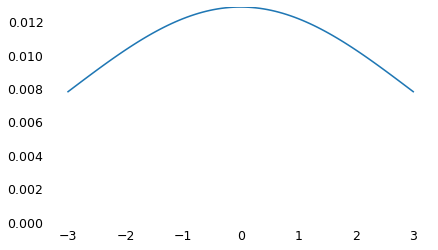

<IPython.core.display.Javascript object>

In [17]:
from scipy.stats import norm

alphas = np.linspace(-3, 3, 91)
alpha_prior = norm.pdf(alphas, 0, 3)
alpha_prior /= alpha_prior.sum()

plt.plot(alphas, alpha_prior)
decorate(ylim=[0, alpha_prior.max()])

The standard deviation of `beta` represents prior belief about how fast the underlying proportion changes.

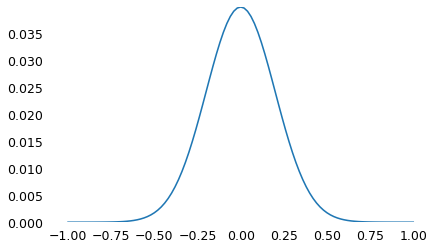

<IPython.core.display.Javascript object>

In [18]:
betas = np.linspace(-1, 1, 101)
beta_prior = norm.pdf(betas, 0, 0.2)
beta_prior /= beta_prior.sum()

plt.plot(betas, beta_prior)
decorate(ylim=[0, beta_prior.max()])

Compute the posterior in the usual way...

In [19]:
AP, BP = np.meshgrid(alpha_prior, beta_prior, indexing="ij")
joint_prior = AP * BP

<IPython.core.display.Javascript object>

In [20]:
from scipy.special import expit
from scipy.stats import binom

joint_posterior = joint_prior.copy()
A, B = np.meshgrid(alphas, betas, indexing="ij")

for x in xs:
    k = ks[x]
    n = ns[x]
    P = expit(A + B * x)
    print(x, k, n, k / n)
    likelihood = binom.pmf(k, n, P)
    joint_posterior *= likelihood

joint_posterior /= joint_posterior.sum()

-4 5 22 0.22727272727272727
-2 27 90 0.3
0 39 151 0.2582781456953642
2 58 228 0.2543859649122807
4 101 395 0.25569620253164554
6 84 406 0.20689655172413793
9 111 675 0.16444444444444445
10 137 592 0.23141891891891891


<IPython.core.display.Javascript object>

Here are the marginal posterior distributions

-1.0224615752840225

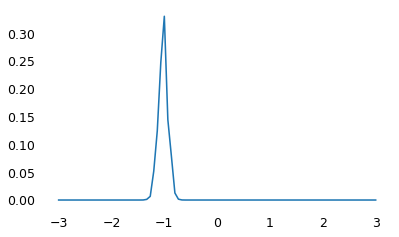

<IPython.core.display.Javascript object>

In [21]:
marginal_alpha = joint_posterior.sum(axis=1)
plt.plot(alphas, marginal_alpha)
np.sum(alphas * marginal_alpha)

-0.039849633111829125

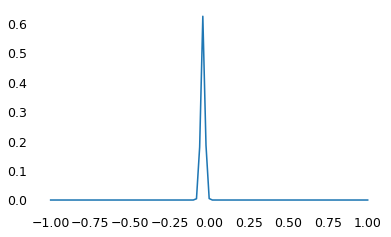

<IPython.core.display.Javascript object>

In [22]:
marginal_beta = joint_posterior.sum(axis=0)
plt.plot(betas, marginal_beta)
np.sum(betas * marginal_beta)

And the joint posterior

In [23]:
def joint_contour(xs, ys, p, cmap="Blues"):
    X, Y = np.meshgrid(xs, ys, indexing="ij")
    plt.contour(X, Y, p, cmap=cmap)

<IPython.core.display.Javascript object>

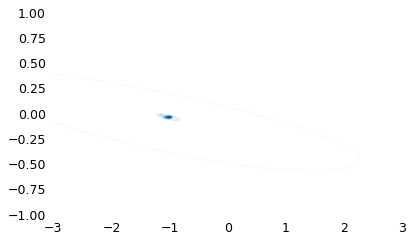

<IPython.core.display.Javascript object>

In [24]:
joint_contour(alphas, betas, joint_posterior)

Now we can extract the posterior mean estimate for the proportion at each point.

In [25]:
ps = [np.sum(joint_posterior * expit(A + B * x)) for x in xs]
pred = pd.Series(ps, actual.index)
pred

x
2008    0.297482
2010    0.280904
2012    0.264922
2014    0.249566
2016    0.234859
2018    0.220816
2021    0.201009
2022    0.194742
dtype: float64

<IPython.core.display.Javascript object>

And a credible interval.

In [26]:
def make_credible_interval(joint_posterior, A, B, xs):
    """ """
    p = joint_posterior.ravel()
    indices = np.random.choice(len(p), p=p, size=201)
    sample_alpha = A.ravel()[indices]
    sample_beta = B.ravel()[indices]

    P = [expit(sample_alpha + sample_beta * x) for x in xs]
    sample_fit = np.transpose(P)
    low, high = np.percentile(sample_fit, [5, 95], axis=0)
    return low, high

<IPython.core.display.Javascript object>

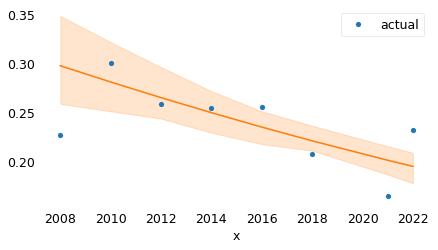

<IPython.core.display.Javascript object>

In [27]:
low, high = make_credible_interval(joint_posterior, A, B, xs)
plt.fill_between(actual.index, low, high, color="C1", alpha=0.2)

pred.plot(color="C1")
actual.plot(style="o", label="actual")
decorate()

## Quadratic

The quadratic model is pretty much the same, but with a quadratic term.
Because it has three parameters, the whole calculation has an additional dimension, so it's more computationally intensive, but still plenty fast for practical purposes.

In [28]:
m = subset["year"].median()
m

2018.0

<IPython.core.display.Javascript object>

In [29]:
subset["y"] = subset[yvar] == yval
subset["x"] = subset["year"] - m
subset["x2"] = (subset["year"] - m) ** 2

<IPython.core.display.Javascript object>

In [30]:
ns = subset.groupby("x")["y"].count()
ns

x
-10.0     22
-8.0      90
-6.0     151
-4.0     228
-2.0     395
 0.0     406
 3.0     675
 4.0     592
Name: y, dtype: int64

<IPython.core.display.Javascript object>

In [31]:
ks = subset.groupby("x")["y"].sum()
xs = ks.index
ks

x
-10.0      5
-8.0      27
-6.0      39
-4.0      58
-2.0     101
 0.0      84
 3.0     111
 4.0     137
Name: y, dtype: int64

<IPython.core.display.Javascript object>

In [32]:
actual = ks / ns
actual.index = xs + m
actual

x
2008.0    0.227273
2010.0    0.300000
2012.0    0.258278
2014.0    0.254386
2016.0    0.255696
2018.0    0.206897
2021.0    0.164444
2022.0    0.231419
Name: y, dtype: float64

<IPython.core.display.Javascript object>

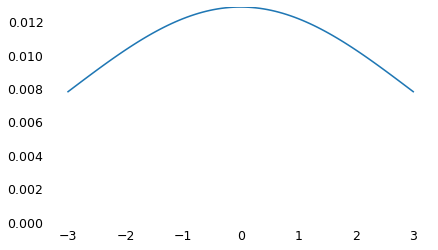

<IPython.core.display.Javascript object>

In [33]:
from scipy.stats import norm

alphas = np.linspace(-3, 3, 91)
alpha_prior = norm.pdf(alphas, 0, 3)
alpha_prior /= alpha_prior.sum()

plt.plot(alphas, alpha_prior)
decorate(ylim=[0, alpha_prior.max()])

In [34]:
std1 = 0.1
std2 = 0.1

<IPython.core.display.Javascript object>

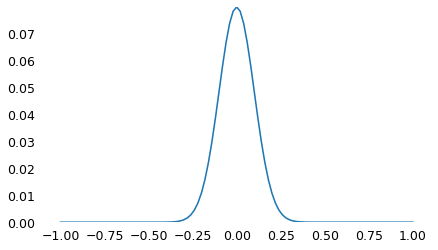

<IPython.core.display.Javascript object>

In [35]:
betas = np.linspace(-1, 1, 101)
beta_prior = norm.pdf(betas, 0, std1)
beta_prior /= beta_prior.sum()

plt.plot(betas, beta_prior)
decorate(ylim=[0, beta_prior.max()])

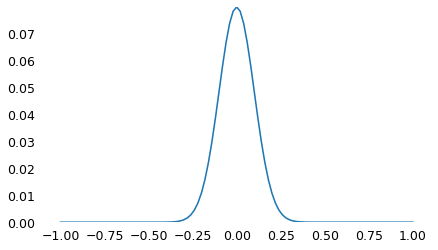

<IPython.core.display.Javascript object>

In [36]:
gammas = np.linspace(-1, 1, 101)
gamma_prior = norm.pdf(gammas, 0, std2)
gamma_prior /= gamma_prior.sum()

plt.plot(gammas, gamma_prior)
decorate(ylim=[0, gamma_prior.max()])

In [37]:
AP, BP, GP = np.meshgrid(alpha_prior, beta_prior, gamma_prior, indexing="ij")
joint_prior = AP * BP * GP

<IPython.core.display.Javascript object>

In [38]:
from scipy.special import expit
from scipy.stats import binom

joint_posterior = joint_prior.copy()
A, B, C = np.meshgrid(alphas, betas, gammas, indexing="ij")

for x in xs:
    k = ks[x]
    n = ns[x]
    P = expit(A + B * x + C * x**2)
    print(x, k, n, k / n)
    likelihood = binom.pmf(k, n, P)
    joint_posterior *= likelihood

joint_posterior /= joint_posterior.sum()

-10.0 5 22 0.22727272727272727
-8.0 27 90 0.3
-6.0 39 151 0.2582781456953642
-4.0 58 228 0.2543859649122807
-2.0 101 395 0.25569620253164554
0.0 84 406 0.20689655172413793
3.0 111 675 0.16444444444444445
4.0 137 592 0.23141891891891891


<IPython.core.display.Javascript object>

-1.2615403317333038

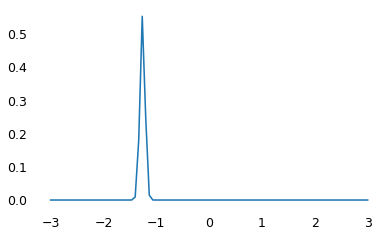

<IPython.core.display.Javascript object>

In [39]:
marginal_alpha = joint_posterior.sum(axis=(1, 2))
plt.plot(alphas, marginal_alpha)
np.sum(alphas * marginal_alpha)

-0.03926508268535597

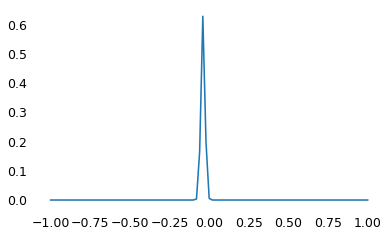

<IPython.core.display.Javascript object>

In [40]:
marginal_beta = joint_posterior.sum(axis=(0, 2))
plt.plot(betas, marginal_beta)
np.sum(betas * marginal_beta)

7.791531274000829e-09

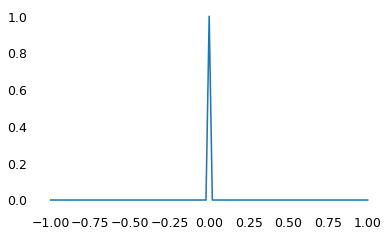

<IPython.core.display.Javascript object>

In [41]:
marginal_gamma = joint_posterior.sum(axis=(0, 1))
plt.plot(gammas, marginal_gamma)
np.sum(gammas * marginal_gamma)

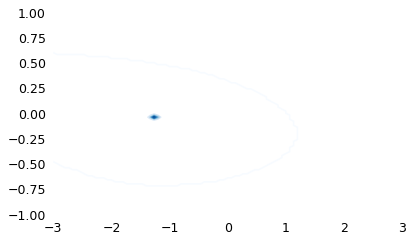

<IPython.core.display.Javascript object>

In [42]:
joint_contour(alphas, betas, joint_posterior.sum(axis=2))

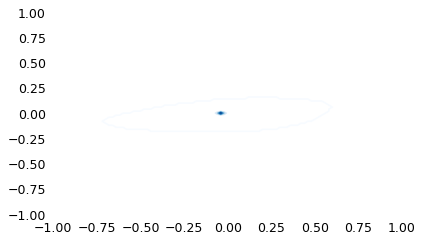

<IPython.core.display.Javascript object>

In [43]:
joint_contour(betas, gammas, joint_posterior.sum(axis=0))

In [44]:
low, high = xs.min(), xs.max()
pred_xs = np.linspace(low, high, 21)
pred_ys = [np.sum(joint_posterior * expit(A + B * x + C * x**2)) for x in pred_xs]
pred = pd.Series(pred_ys, pred_xs + m)

<IPython.core.display.Javascript object>

<Axes: xlabel='x'>

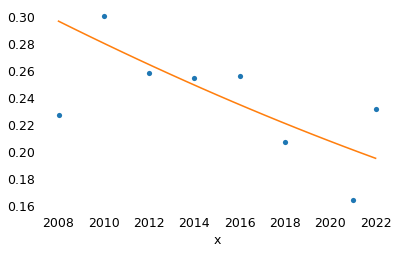

<IPython.core.display.Javascript object>

In [45]:
actual.plot(style="o")
pred.plot()

Copyright 2024 Allen Downey 

The code in this notebook and `utils.py` is under the [MIT license](https://mit-license.org/).